In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "3" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
import torch 
torch.cuda.is_available()

True

# Hypothesis Testing Automatically Discovered Circuits

Procedure: 
- Compute prune scores (via attribution patching) 
- Search over different thresholds to find the smallest circuit where the null hypotheis of Equivalence / Dominance cannot be rejected 
- Prune edges from circuit that are not in paths to the output, or in the case of resample ablation cannot be reached from the input
- Test whether each edge in the circuit is minimal 
- Test whether the circuit is complete (by seeing if the null hypothesis on the independence test can be rejected)



In [3]:
import os
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import torch
import torch as t
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
from tqdm import tqdm

from omegaconf import OmegaConf


from auto_circuit.data import PromptPairBatch, PromptDataLoader
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.types import (BatchKey, PruneScores, CircuitOutputs, AblationType, 
                                Edge, BatchOutputs, EdgeCounts)
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.prune_algos.activation_patching import act_patch_prune_scores
from auto_circuit.prune_algos.ACDC import acdc_prune_scores
from auto_circuit.prune_algos.subnetwork_probing import subnetwork_probing_prune_scores
from auto_circuit.prune_algos.circuit_probing import circuit_probing_prune_scores
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.custom_tqdm import tqdm
from auto_circuit.utils.tensor_ops import desc_prune_scores
from auto_circuit.utils.graph_utils import edge_counts_util

from auto_circuit_tests.prune_algos import PruneAlgo
from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc, DIV_ANSWER_FUNCS
# from auto_circuit_tests.faithful_metrics import FaithfulMetric

from auto_circuit_tests.edge_scores import compute_edge_scores
from auto_circuit_tests.utils.auto_circuit_utils import (
    run_circuit_with_edge_ablated,
    run_circuit_with_edges_ablated, 
    run_fully_ablated_model, 
    flat_prune_scores_ordered
)

from auto_circuit_tests.faith_metrics import compute_faith_metrics
from auto_circuit_tests.hypo_tests.equiv_test import equiv_tests
from auto_circuit_tests.hypo_tests.minimality_test import (
    run_circuits_inflated_ablated, 
    score_diffs,
    minimality_test_edge,
    minimality_test, 
)
from auto_circuit_tests.hypo_tests.indep_test import independence_tests, indep_test
from auto_circuit_tests.hypo_tests.utils import (
    join_values, 
    remove_el,
    edges_from_mask, 
    result_to_json, 
)
from auto_circuit_tests.edge_graph import (
    SeqGraph,  
    sample_paths, 
    SampleType,
    edge_in_path, 
    find_unused_edges,
    visualize_graph
)

from auto_circuit_tests.tasks import TASK_DICT, TASK_TO_OUTPUT_ANSWER_FUNCS
from auto_circuit_tests.utils.auto_circuit_utils import edge_name
from auto_circuit_tests.utils.utils import (
    repo_path_to_abs_path, 
    load_cache, 
    save_cache, 
    save_json, 
    load_json, # should probably move this to auto_circuit_tests.utils
    get_el_rank
)
from auto_circuit_tests.utils.utils import get_exp_dir


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# config class
from dataclasses import dataclass, field
@dataclass 
class Config: 
    task: str = "Docstring Component Circuit" # check how many edges in component circuit (probably do all but ioi toen)
    ablation_type: AblationType = AblationType.TOKENWISE_MEAN_CLEAN
    grad_func: GradFunc = GradFunc.LOGPROB
    answer_func: AnswerFunc = AnswerFunc.KL_DIV
    eval_grad_func: Optional[GradFunc] = None # TODO: used to evaluate faithfulness
    prune_algo: PruneAlgo = PruneAlgo.ATTR_PATCH
    eval_answer_func: Optional[AnswerFunc] = None
    ig_samples: Optional[int] = 2
    layerwise: bool = True
    edge_counts: EdgeCounts = EdgeCounts.LOGARITHMIC
    tao_bases: list[float] = field(default_factory=lambda: [1, 5])
    tao_exps: list[float] = field(default_factory=lambda: list(range(-5, -1)))
    prune_score_thresh: bool = False
    null_good: bool = True
    alpha: float = 0.05
    epsilon: Optional[float] = 0.1
    q_star: float = 0.9 
    n_paths: int = 200
    sample_type: SampleType = SampleType.RANDOM_WALK
    # TODO: remove these?
    min_equiv_all_edges_thresh = 1000
    max_edges_to_test_in_order: int = 0 #TODO: change to 125
    max_edges_to_test_without_fail: int = 500 #TODO: change to 125
    save_cache: bool = True
    
    def __post_init__(self):
        # always override clean_corrupt for now
        self.clean_corrupt = "corrupt" if self.ablation_type == AblationType.RESAMPLE else None

        # set eval_grad_func and faith_answer_func to logit and max diff if answer_func is div
        if self.answer_func in DIV_ANSWER_FUNCS: 
            if self.eval_grad_func is None:
                self.eval_grad_func = GradFunc.LOGIT
            if self.eval_answer_func is None:
                self.eval_answer_func = AnswerFunc.MAX_DIFF

In [6]:
# initialize config 
conf = Config()
#get config overrides if runnign from command line
if not is_notebook():
    import sys 
    conf_dict = OmegaConf.merge(OmegaConf.structured(conf), OmegaConf.from_cli(sys.argv[1:]))
    conf = Config(**conf_dict)

In [7]:
# handle directories
task_dir, ablation_dir, out_answer_dir, ps_dir, edge_dir, exp_dir = get_exp_dir(
    task_key=conf.task, 
    ablation_type=conf.ablation_type,
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    prune_algo=conf.prune_algo,
    ig_samples=conf.ig_samples,
    layerwise=conf.layerwise,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
    q_star=conf.q_star,
    prune_score_thresh=conf.prune_score_thresh,
)
exp_dir.mkdir(parents=True, exist_ok=True)

In [8]:
# initialize task
task = TASK_DICT[conf.task]
# IOI model is bigger, need smaller batch size to fit on A4000
if "Indirect Object Identification" in task.key:
    task.batch_size = 32 # int(task.batch_size / 2) 
    task.batch_count = 8 # int(task.batch_count * 2)
task.shuffle = False
task.init_task()

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/transformer_lens/utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

Loaded pretrained model attn-only-4l into HookedTransformer
seq_len before divergence None
seq_len after divergence None


# Prune Scores

## ACDC Prune Scores

In [9]:
if conf.prune_algo == PruneAlgo.ACDC:
    auto_ps_path = out_answer_dir / "auto_prune_scores.pkl"
    if auto_ps_path.exists():
        auto_prune_scores = torch.load(auto_ps_path)
    else:
        if conf.task == "Indirect Object Identification Token Circuit":
            print("cannot run ACDC on IOI token circuit, too large")
            exit()
        auto_prune_scores = acdc_prune_scores(
            model=task.model, 
            dataloader=task.train_loader, 
            official_edges=None,
            tao_exps=conf.tao_exps,
            tao_bases=conf.tao_bases,
            faithfulness_target=conf.answer_func.value, 
        )
        if conf.save_cache:
            torch.save(auto_prune_scores, auto_ps_path)
    taos = sorted([tao_base * 10**tao_exp for tao_base, tao_exp in product(conf.tao_bases, conf.tao_exps)])

## Circuit Probing Prune Scores

In [10]:
if conf.prune_algo == PruneAlgo.CIRC_PROBE and conf.answer_func == AnswerFunc.KL_DIV:
    circ_probe_ps_path = out_answer_dir / "circ_probe_prune_scores.pkl"
    # if circ_probe_ps_path.exists():
    #     circ_probe_prune_scores = torch.load(circ_probe_ps_path)
    # else:
    circ_probe_prune_scores = circuit_probing_prune_scores(
        model=task.model, 
        dataloader=task.train_loader, 
        official_edges=None,
        tree_optimisation=True,
        faithfulness_target=conf.answer_func.value, 
        circuit_sizes=edge_counts_util(task.model.edges, conf.edge_counts, zero_edges=False),
        learning_rate=0.1,
        epochs=100, 
        regularize_lambda=0.1, 
        show_train_graph=is_notebook(),
    )
    if conf.save_cache:
        torch.save(circ_probe_prune_scores, circ_probe_ps_path)

## Activation Patching Prune Scores

In [11]:
# load from cache if exists 
act_ps_path = out_answer_dir / "act_patch_prune_scores.pt"
if act_ps_path.exists():
    act_prune_scores = torch.load(act_ps_path, map_location="cpu")
else:
    act_prune_scores = None

# # if act_patch and act_patch doesn't exist, exit
# if conf.prune_algo == PruneAlgo.ACT_PATCH and act_prune_scores is None:
#     print("act_patch_prune_scores.pkl not found, exiting")
#     exit()

/tmp/ipykernel_3967513/3009715161.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_prune_scores = torch.load(act_ps_path, map_location="cpu")


##  Attribution Patching Prune Scores

In [14]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH:
    attr_ps_name = "attrib_patch_prune_scores"
    attr_ps_path = (ps_dir / attr_ps_name).with_suffix(".pt")
    # if (attr_ps_path).exists():
    #     attr_prune_scores = torch.load(attr_ps_path)
    # else: 
    max_layer = max([edge.src.layer for edge in task.model.edges])

    attr_prune_scores = mask_gradient_prune_scores(
        model=task.model, 
        dataloader=task.train_loader,
        official_edges=None,
        grad_function=conf.grad_func.value, 
        answer_function=conf.answer_func.value, #answer_func,
        mask_val=0.0 if conf.ig_samples is None else None, 
        ablation_type=conf.ablation_type,
        integrated_grad_samples=conf.ig_samples, 
        layers=max_layer if conf.layerwise else None,
        clean_corrupt=conf.clean_corrupt,
    )
    attr_prune_scores = {mod_name: score.to("cpu") for mod_name, score in attr_prune_scores.items()}
    if conf.save_cache:
        torch.save(attr_prune_scores, attr_ps_path)

Layer: 4██████████| 5/5 [00:04<00:00,  1.17it/s]


##  Compare Activation and Attribution Patching

In [15]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    # order = sorted(list(act_prune_scores.keys()), key=lambda x: int(x.split('.')[1]))
    order = list(act_prune_scores.keys())
    act_prune_scores_flat = flat_prune_scores_ordered(act_prune_scores, order=order)
    attr_prune_scores_flat = flat_prune_scores_ordered(attr_prune_scores, order=order)

### MSE

In [16]:
# mse and median se
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    mse_result_name = "act_attr_mse"
    mse_result_path = (ps_dir / mse_result_name).with_suffix(".json")
    if mse_result_path.exists():
        mse_result = load_json(ps_dir, mse_result_name + '.json')
    else:
        prune_score_diffs = [
            (act_prune_scores[mod_name] - attr_prune_scores[mod_name]).flatten()
            for mod_name, _patch_mask in task.model.patch_masks.items()
        ]
        sq_error = torch.concat(prune_score_diffs).pow(2)
        median_se = sq_error.median()
        mean_se = sq_error.mean()
        mse_result = {
            "median_se": median_se.item(),
            "mean_se": mean_se.item(),
        }
        save_json(mse_result, ps_dir, mse_result_name)
    print(mse_result)

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/TOKENWISE_MEAN_CLEAN/LOGPROB_KL_DIV/2_True/act_attr_mse.json
{'median_se': 0.0007674206281080842, 'mean_se': 0.17973683774471283}


### Spearman Rank Correlation

In [17]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    from scipy import stats 
    abs_corr, abs_p_value = stats.spearmanr(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu())
    corr, p_value = stats.spearmanr(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu())
    print(f"abs corr: {abs_corr}, abs p-value: {abs_p_value}")
    print(f"corr: {corr}, p-value: {p_value}")

    spearman_results = {
        "abs_corr": abs_corr,
        "abs_p_value": abs_p_value,
        "corr": corr,
        "p_value": p_value,
    }
    save_json(spearman_results, ps_dir, "spearman_results")

abs corr: 0.5941286039907641, abs p-value: 4.487621335496878e-123
corr: 0.07477698551735981, p-value: 0.007417738045897225
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/TOKENWISE_MEAN_CLEAN/LOGPROB_KL_DIV/2_True/spearman_results.json


### Plot Rank 

In [20]:
# get rank for scores
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    act_prune_scores_rank = get_el_rank(act_prune_scores_flat.cpu())
    attr_prune_scores_rank = get_el_rank(attr_prune_scores_flat.cpu())

    act_prune_scores_0 = (act_prune_scores_flat == 0).cpu()
    act_prune_scores_0_rank = act_prune_scores_rank[act_prune_scores_0]
    min_0_rank, max_0_rank = None, None
    if len(act_prune_scores_0_rank) > 0:
        min_0_rank, max_0_rank = act_prune_scores_0_rank.min().item(), act_prune_scores_0_rank.max().item()

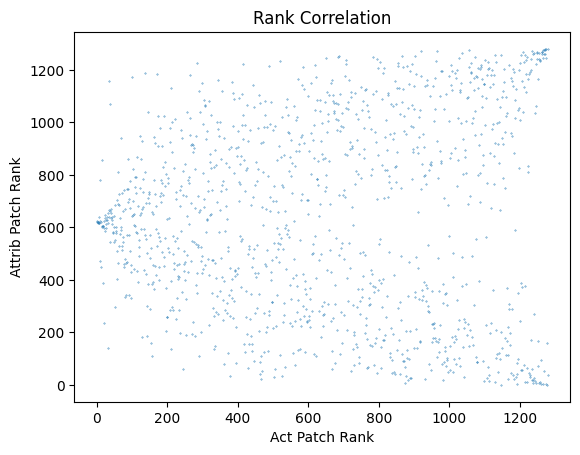

In [22]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    # TODO: plot x=0
    plt.scatter(act_prune_scores_rank, attr_prune_scores_rank, s=0.1)
    # plot min rank, max rank as vertical lines
    if min_0_rank is not None:
        plt.axvline(min_0_rank, color='blue', linestyle='--')
        plt.axvline(max_0_rank, color='blue', linestyle='--')
        # shade area between min and max rank
        plt.axvspan(min_0_rank, max_0_rank, color='lightblue', alpha=0.5)
    
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation")

    plt.savefig(ps_dir / "rank_corr.png")
    # plt.close()

In [17]:
# TODO: I think there must be a bug? 
# get rank for scores
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    act_prune_scores_abs_rank = get_el_rank(act_prune_scores_flat.abs().cpu())
    attr_prune_scores_abs_rank = get_el_rank(attr_prune_scores_flat.abs().cpu())

    max_0_rank = act_prune_scores_abs_rank[act_prune_scores_0].max().item()

    plt.scatter(act_prune_scores_abs_rank, attr_prune_scores_abs_rank, s=0.1)
    # plot max rank as vertical lines
    plt.axvline(max_0_rank, color='blue', linestyle='--')
    # shade area between min and max rank
    plt.axvspan(0, max_0_rank, color='lightblue', alpha=0.5)

    
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation Abs")
    plt.savefig(ps_dir / "rank_corr_abs.png")
    plt.close()

### Compute Fraction of "Mis-Signed" Components

In [18]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    num_missigned = (act_prune_scores_flat.sign() != attr_prune_scores_flat.sign()).sum()
    frac_missigned = num_missigned / len(act_prune_scores_flat)
    print(f"Fraction of missigned: {frac_missigned}")
    save_json({"frac_missigned": frac_missigned.item()}, ps_dir, "missigned")

### Compute Fraction of Edges Recovered for Each Edge Threshold

In [19]:
# for different edge thresholds, compute fraction of edges not included in top k
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    edge_counts = edge_counts_util(task.model.edges, conf.edge_counts, zero_edges=True)

    frac_edges_recovered: Dict[int, float] = {}

    for edge_count in edge_counts:
        # get indicies where act_prune_scores_abs_rank >= task.n_edges - edge_count
        act_indices = act_prune_scores_abs_rank >= task.model.n_edges - edge_count
        frac_edges_recovered[edge_count] = (attr_prune_scores_abs_rank[act_indices] >= task.model.n_edges - edge_count).to(t.float).mean().item()

    save_json(frac_edges_recovered, ps_dir, "frac_edges_recovered")

### Parition by Dest Component

We partion by Dest B/c we expect difficulties to arise from estimating effects that route through non-linearities

In [20]:
from auto_circuit_tests.edge_graph import NodeType

def mod_name_to_layer_and_node_type(mod_name: str) -> Tuple[int, NodeType]:
    _blocks, layer, node_type_str = mod_name.split('.')
    layer = int(layer)
    if node_type_str == "hook_k_input":
        node_type = NodeType.K 
    elif node_type_str == "hook_q_input":
        node_type = NodeType.Q
    elif node_type_str == "hook_v_input":
        node_type = NodeType.V
    elif node_type_str == "hook_resid_post":
        node_type = NodeType.RESID_END 
    elif node_type_str == "hook_mlp_in":
        node_type = NodeType.MLP
    else: 
        raise ValueError(f"Unknown node type: {node_type_str}")
    return layer, node_type

In [21]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    from auto_circuit_tests.edge_graph import NodeType
    # compute ranking by flatten by order, including module name 
    def prune_score_rankings_by_component(
        prune_scores: PruneScores, 
        prune_scores_rank: torch.Tensor, 
        order: list[str]
    ) -> dict[tuple[int, NodeType], list[int]]:
        # collect mod_name ranking tuples
        flat_mod_names = [] 
        for mod_name in order:
            flat_mod_names.extend([mod_name for _ in range(prune_scores[mod_name].numel())])
        # get ranking by component type and layer
        rank_by_component: dict[tuple[int, NodeType], list[int]] = defaultdict(list)
        for mod_name, rank in zip(flat_mod_names, prune_scores_rank):
            layer, node_type = mod_name_to_layer_and_node_type(mod_name)
            rank_by_component[(layer, node_type)].append(rank)
        return rank_by_component

    act_rank_by_component = prune_score_rankings_by_component(act_prune_scores, act_prune_scores_abs_rank, order)
    attr_rank_by_component = prune_score_rankings_by_component(attr_prune_scores, attr_prune_scores_abs_rank, order)

In [22]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    import matplotlib.pyplot as plt
    import numpy as np

    # plot ranks for each component type all in one figure
    n_layers = max([layer for layer, _ in act_rank_by_component.keys()])
    components = sorted(list(set([node_type for _, node_type in act_rank_by_component.keys()])), key=lambda x: x.value)

    # Create a 2D array to store the Axes objects
    axs = np.empty((len(components), n_layers + 1), dtype=object)

    # Create the figure without subplots initially
    fig = plt.figure(figsize=(3 * (n_layers+1), 3 * len(components)))


    rank_correlations: dict[tuple[int, NodeType], float] = {}
    for layer in range(0, n_layers + 1):
        for i, node_type in enumerate(components):
            act_ranks = act_rank_by_component[(layer, node_type)]
            attr_ranks = attr_rank_by_component[(layer, node_type)]
            
            if len(act_ranks) == 0 and len(attr_ranks) == 0:
                continue

            # compute rank correlation
            corr, p_value = stats.spearmanr(act_ranks, attr_ranks)
            rank_correlations[(layer, node_type)] = corr
            
            # Create a subplot only if there's data to plot
            ax = fig.add_subplot(len(components), (n_layers+1), (i * (n_layers+1)) + layer+1)
            ax.scatter(act_ranks, attr_ranks, s=1)
            # set title below scatter plot
            ax.set_title(f"Correlation: {corr:.2f}", y=-0.20)

            
            # Store the Axes object in our 2D array
            axs[i, layer - 1] = ax

            # Add x-label at the top
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.set_xlabel(f"Layer {layer}", fontweight='bold')
            
            # Add y-label on the left
            if layer == 0 or node_type == NodeType.RESID_END:
                ax.set_ylabel(str(node_type.name), fontweight='bold')

    # Remove empty spaces in the figure
    fig.tight_layout()
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # save figure

    plt.savefig(ps_dir / "rank_corr_by_component.png")
    plt.close()


    # save rank correlations
    save_json({str(k): v for k, v in rank_correlations.items()}, ps_dir, "rank_cor_by_component")

### Plot Scores

In [23]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("symlog")
    plt.yscale("symlog")
    plt.savefig(ps_dir / "act_attr_scores.png")
    plt.close()

In [24]:
if conf.prune_algo == PruneAlgo.ATTR_PATCH and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("log")
    plt.yscale("log")
    plt.savefig(ps_dir / "act_attr_abs_scores.png")
    plt.close()


# Construt Circuits from Prune Scores 

Constructing circuits from prune scores using either edge or fraction of prune score thresholds

In [25]:
# set prune scores
if conf.prune_algo == PruneAlgo.ACDC:
    prune_scores = auto_prune_scores
elif conf.prune_algo == PruneAlgo.CIRC_PROBE:
    prune_scores = circ_probe_prune_scores
elif conf.prune_algo == PruneAlgo.ACT_PATCH:
    prune_scores = act_prune_scores
else:
    prune_scores = attr_prune_scores

prune_scores = {mod_name: score.to(task.device) for mod_name, score in prune_scores.items()}
# sort prune scores
sorted_prune_scores = desc_prune_scores(prune_scores)

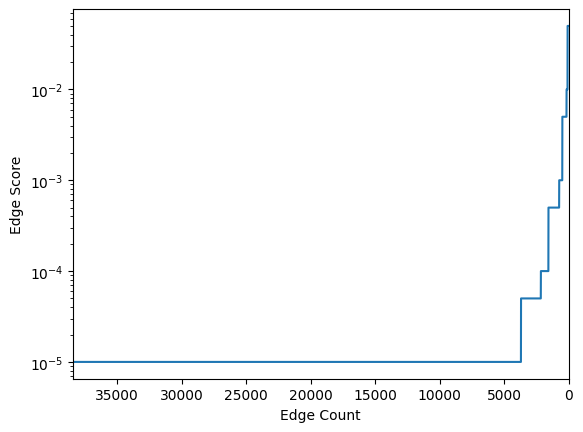

In [26]:
# plot prune scores
def plot_prune_scores(edge_scores):
    fig, ax = plt.subplots()
    # plot edge scores with x labels max to 0 
    ax.plot(sorted(edge_scores, reverse=True))
    ax.set_xlim(len(edge_scores), 0)
    # log axis 
    ax.set_yscale('log')
    ax.set_xlabel("Edge Count")
    ax.set_ylabel("Edge Score")
    return fig, ax

fig, ax = plot_prune_scores(sorted_prune_scores.cpu().numpy().tolist())
plt.savefig(ps_dir / "edge_scores.png")
# plt.close()

In [27]:
# compute n_edges 
from auto_circuit.utils.graph_utils import edge_counts_util
circ_edges = []
if conf.prune_algo == PruneAlgo.ACDC:
     circ_edges = [
         t.sum(t.cat([t.flatten(v) for v in auto_prune_scores.values()]) > tao).item()
        for tao in taos
    ]
     circ_thresholds = taos[1:] + [t.inf] # prune scores set to tau if change less than tau
elif conf.prune_algo == PruneAlgo.CIRC_PROBE:
     # get size of each circuit and thresholds 
    circ_edges = edge_counts_util(task.model.edges, prune_scores=prune_scores, zero_edges=False)
    circ_thresholds = [sorted_prune_scores[n_edges-1].item() for n_edges in circ_edges]
else:
    circ_edges = edge_counts_util(task.model.edges, conf.edge_counts, zero_edges=False)
    circ_thresholds = [sorted_prune_scores[n_edges-1].item() for n_edges in circ_edges]

save_json(circ_edges, edge_dir, "n_circ_edges")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/n_circ_edges.json


# Faithfulness: % Loss Recovered and Equivalence Test

Use equivalence test from Shi et al to test a. if not equivalent and b. if equivalent

We also compute: 
- mean absolute error: E[abs(score(M) - score(C))] 
(spiritually similar to Transfomer Circuits not Robust and this comment https://www.lesswrong.com/posts/kcZZAsEjwrbczxN2i/causal-scrubbing-appendix#hJoCMcgXpk8jBLvb7, we don't do fraction of recovered b/c the negatives are weird and annoying)
- mean difference: E[score(M)] - E[score(C)] 
(kind of a middle ground, measuring bias)
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)] 
(SAE work, similar to causal scrubbing, don't need to worry about variance)

In [28]:
# first full model outt and ablated model out

with t.inference_mode():
    model_out_train: BatchOutputs = {
        batch.key: task.model(batch.clean)[task.model.out_slice] 
        for batch in task.train_loader
    }
    model_out_test: BatchOutputs = {
        batch.key: task.model(batch.clean)[task.model.out_slice] 
        for batch in task.test_loader
    }

ablated_out_train: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.train_loader,
    ablation_type=conf.ablation_type,
)

ablated_out_test: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.test_loader,
    ablation_type=conf.ablation_type,
)

Pruning Batch 1██████████| 2/2 [00:00<00:00,  7.83it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00,  7.15it/s]


In [29]:
# next get circuit outs for each threshold
from auto_circuit.prune import run_circuits
from auto_circuit.types import CircuitOutputs, PatchType
circuit_outs_train: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)
circuit_outs_train = dict(circuit_outs_train)

circuit_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)
circuit_outs_test = dict(circuit_outs_test)

Pruning Batch 1██████████| 2/2 [00:01<00:00,  1.32it/s]
Pruning Batch 1██████████| 2/2 [00:01<00:00,  1.30it/s]


## Faithfulness Metrics

- mae: E[abs(score(M) - score(C))] 
- mean difference: E[score(M)] - E[score(C)] 
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)]

In [30]:
[batch.key for batch in task.train_loader], [k for k in model_out_train.keys()], 

([3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698])

In [31]:
[[k for k in out.keys()] for out in circuit_outs_train.values()]

[[3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698],
 [3406728206934413423, 8911613281540895698]]

In [32]:
faith_metric_results_train, faith_metrics_train = compute_faith_metrics(
    task.train_loader,
    model_out_train,
    ablated_out_train,
    conf.grad_func,
    conf.answer_func,
    circs_outs=circuit_outs_train,
)

faith_metric_results_test, faith_metrics_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    conf.grad_func,
    conf.answer_func,
    circs_outs=circuit_outs_test,
)

save_json(faith_metric_results_train, edge_dir, "faith_metric_results_train")
save_json(faith_metrics_train, edge_dir, "faith_metrics_train")
save_json(faith_metric_results_test, edge_dir, "faith_metric_results_test")
save_json(faith_metrics_test, edge_dir, "faith_metrics_test")

Computing faith metrics██████████| 8/8 [00:00<00:00, 161.83it/s]
Computing faith metrics██████████| 8/8 [00:00<00:00, 151.23it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metric_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metrics_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metric_results_test.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metrics_test.json


In [33]:
# faith metrics eval 
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    faith_metric_results_train_eval, faith_metrics_train_eval = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        conf.eval_grad_func,
        conf.eval_answer_func,
        circs_outs=circuit_outs_train,
    )

    faith_metric_results_test_eval, faith_metrics_test_eval = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        conf.eval_grad_func,
        conf.eval_answer_func,
        circs_outs=circuit_outs_test,
    )
    save_json(faith_metric_results_train_eval, edge_dir, "faith_metric_results_train_eval")
    save_json(faith_metrics_train_eval, edge_dir, "faith_metrics_train_eval")
    save_json(faith_metric_results_test_eval, edge_dir, "faith_metric_results_test_eval")
    save_json(faith_metrics_test_eval, edge_dir, "faith_metrics_test_eval")

Computing faith metrics██████████| 8/8 [00:00<00:00, 224.97it/s]
Computing faith metrics██████████| 8/8 [00:00<00:00, 224.30it/s]


Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metric_results_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metrics_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metric_results_test_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metrics_test_eval.json


## Equivalence Tests

In [34]:
use_eval_metrics = conf.answer_func in DIV_ANSWER_FUNCS
equiv_test_results_train = equiv_tests(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    grad_func=conf.grad_func if not use_eval_metrics else conf.eval_grad_func,
    answer_func=conf.answer_func if not use_eval_metrics else conf.eval_answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    circuit_outs=circuit_outs_train,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

equiv_test_results_test = equiv_tests(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    grad_func=conf.grad_func if not use_eval_metrics else conf.eval_grad_func,
    answer_func=conf.answer_func if not use_eval_metrics else conf.eval_answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    circuit_outs=circuit_outs_test,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

save_json(equiv_test_results_train, edge_dir, "equiv_test_results_train")
save_json(equiv_test_results_test, edge_dir, "equiv_test_results_test")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/equiv_test_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/equiv_test_results_test.json


## TODO: Sufficiency Test, and Expected Loss Recovered with Respect to Expected Value of Random Circuit of the same size

## Plot % loss recovered and Equiv Test Results Along Frac Edges / Frac Prune Scores

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction
from auto_circuit_tests.hypo_tests.equiv_test import EquivResult
from auto_circuit_tests.hypo_tests.indep_test import IndepResult
from typing import cast

def plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results: Dict[int, Dict[str, float]], 
    equiv_test_results: Optional[Dict[int, Union[EquivResult, IndepResult]]]=None,
    title: str = "", 
    result_type: Optional[Literal["equiv", "indep"]] = "equiv",
    x_label: str = "Edges"
):
    n_edges = list(faith_metric_results.keys())
    fracs = [n_edge / task.model.n_edges for n_edge in n_edges]
    frac_loss_recovered = [faith_metric_results[n_edge]["frac_mean_diff_recovered"] for n_edge in n_edges]
    

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot line
    ax.plot(fracs, frac_loss_recovered, color='blue')

    good_color = 'green'
    bad_color = 'blue'

    # color points based on hypothesis test results
    if result_type == "equiv":
        equiv_test_results = cast(Dict[int, EquivResult], equiv_test_results)
        reject_equivs = [result.reject_equiv for result in equiv_test_results.values()]
        reject_non_equivs = [result.reject_non_equiv for result in equiv_test_results.values()]
        for frac, loss, reject_equiv, reject_non_equiv in zip(fracs, frac_loss_recovered, reject_equivs,reject_non_equivs):
            color = 'light' + good_color if reject_non_equiv else (good_color if not reject_equiv else bad_color)
            ax.scatter(frac, loss, color=color, s=100, zorder=5)  # s is the size of the dot, zorder ensures it's on top
        
        ax.scatter([], [], color='light' + good_color, label='Non-Equiv Rejected', s=100)
        ax.scatter([], [], color=good_color, label='Equiv Not Rejected', s=100)
        ax.scatter([], [], color=bad_color, label='Equiv Rejected', s=100)
        ax.legend()
    elif result_type == "indep": 
        indep_test_results = cast(Dict[int, IndepResult], equiv_test_results)
        reject_indeps = [result.reject_null for result in indep_test_results.values()]
        for frac, loss, reject_indep in zip(fracs, frac_loss_recovered, reject_indeps):
            color = 'light' + good_color if not reject_indep else bad_color
            ax.scatter(frac, loss, color=color, s=100, zorder=5)
        
        ax.scatter([], [], color=good_color, label='Indep Not Rejected', s=100)
        ax.scatter([], [], color=bad_color, label='Indep Rejected', s=100)
        

    ax.set_xlabel(f"Fraction of Total {x_label}")
    ax.set_ylabel("Fraction of Loss Recovered")
    ax.set_title(title)

    # horizontal line at 0.95
    ax.axhline(0.95, color='r', linestyle='--')

    # Set x-axis ticks and labels
    x_ticks = np.arange(0, 1.0, 0.1)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{x:.1f}' for x in x_ticks])

    # Set x-axis limits
    ax.set_xlim(0, 1.0)


    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    return fig, ax

In [36]:
# plot results using div answer function (no equivalence results)
if use_eval_metrics:
    # TODO: figure out why this plotting is off
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_train,
        title="(Train) Fraction of Loss Recovered",
        result_type=None,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_results_train.png")
    plt.close()

In [37]:
# plot results using div answer function (no equivalence results)
if use_eval_metrics:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_test,
        title="(Test) Fraction of Loss Recovered",
        result_type=None,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_results_test.png")
    plt.close()

In [38]:
# TODO: figure out why this plotting is off

fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_train if not use_eval_metrics else faith_metric_results_train_eval, 
    equiv_test_results_train,
    title="(Train) Fraction of Loss Recovered and Equiv Test Results",
    result_type="equiv",
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_train.png")
plt.close()


In [39]:
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_test if not use_eval_metrics else faith_metric_results_test_eval, 
    equiv_test_results_test,
    title="(Test) Fraction of Loss Recovered and Equiv Test Results",
    result_type="equiv",
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_test.png")
plt.close()

# Minimality of Smallest Circuit with %loss recovered > 0.95

## Find Smallest Equivalent Circuit

In [40]:
flat_ps = flat_prune_scores_ordered(prune_scores, order=prune_scores.keys())

In [41]:
# find smallest equiv circuit on training distribution
edge_counts_equiv_idx = [
    i for i, (k, v) in enumerate(equiv_test_results_train.items())
    if faith_metric_results_train[k]['frac_mean_diff_recovered'] > 0.95 
    #and v.reject_null 
]
n_edges_min_equi_idx = min(edge_counts_equiv_idx) if edge_counts_equiv_idx else -1
n_edges_min_equiv = circ_edges[n_edges_min_equi_idx]
threshold = circ_thresholds[n_edges_min_equi_idx]

# get edges of circuit
edge_mask = {k: torch.abs(v) >= threshold for k, v in prune_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, task.token_circuit)
save_json([(edge.seq_idx, edge.name) for edge in  edges], edge_dir, "min_equiv_edges_train")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/min_equiv_edges_train.json


In [42]:
valid_task = TASK_TO_OUTPUT_ANSWER_FUNCS[conf.task] == (conf.grad_func, conf.answer_func) or conf.answer_func in DIV_ANSWER_FUNCS
test_smallest = valid_task and len(edges) < 20_000

## Plot Pruned Smallest Equivalent Circuit

In [43]:
if test_smallest and not conf.prune_algo == PruneAlgo.ACDC:
    fig = draw_seq_graph(
        model=task.model,
        prune_scores=prune_scores,
        score_threshold=threshold,
        show_all_seq_pos=True,
        orientation="h",
        display_ipython=False,#is_notebook(),
        seq_labels=task.test_loader.seq_labels,
    )
    fig.write_image(repo_path_to_abs_path(edge_dir / "smallest_equiv_circ_graph_train.png"))

## Find Unused Edges

Note: Seems like there is some leakage, not exactly sure why, but I guess its fine, not using this anyway

In [44]:
if test_smallest:
    # from auto_circuit_tests.edge_graph import find_unused_edges
    def sum_prune_scores(edges: list[Edge]) -> t.Tensor:
        return sum([
            torch.abs(prune_scores[edge.dest.module_name][edge.patch_idx])
            for edge in edges
        ])
    # find unused edges
    used_edges, unused_edges, _circ_graph = find_unused_edges(
        edges, conf.ablation_type, token_circuit=task.token_circuit, attn_only=task.model.cfg.attn_only
        )
    # get prune scores for each unused edge 
    unused_edge_prune_scores_train = {
        edge: prune_scores[edge.dest.module_name][edge.patch_idx]
        for edge in unused_edges
    }
    # save unused edges with prune scores
    # save_json(unused_edge_prune_scores_train, edge_dir, "unused_edges_train")
    print(f"Fraction of unused edges: {len(unused_edges) / len(edges)}")
    save_json(len(unused_edges) / len(edges), edge_dir, "frac_unused_edges")
    # save fraction of prune scores attributed to unused edges in circuit
    total_circuit_prune_scores = sum_prune_scores(edges)
    unused_edge_prune_scores_abs = sum_prune_scores(unused_edges)
    save_json((unused_edge_prune_scores_abs / total_circuit_prune_scores).item(), edge_dir, "frac_unused_edge_scores")

Fraction of unused edges: 0.0
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/frac_unused_edges.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/frac_unused_edge_scores.json


### Verify Pruned Smallest Circuit Still Equivalent and achieves >95% loss recovered

In [45]:
if test_smallest:
    from auto_circuit.types import PruneScores
    # get prune score mask
    def edges_to_prune_score_mask(edges: list[Edge]) -> t.Tensor:
        mask = task.model.new_prune_scores()
        for edge in edges:
            mask[edge.dest.module_name][edge.patch_idx] = 1
        return mask

    # compute circuit outputs for used edges 
    def run_circuit_from_mask(
        mask: PruneScores, 
        dataloader: PromptDataLoader,
    ) -> CircuitOutputs:
        circuit_out: CircuitOutputs = run_circuits(
            model=task.model, 
            dataloader=dataloader,
            prune_scores=mask,
            thresholds = [0.5],
            patch_type=PatchType.TREE_PATCH, 
            ablation_type=conf.ablation_type,
            reverse_clean_corrupt=False, 
        )
        return circuit_out

    used_edges_mask = edges_to_prune_score_mask(used_edges)
    used_edges_out = run_circuit_from_mask(used_edges_mask, task.train_loader)

Pruning Batch 1██████████| 2/2 [00:00<00:00,  9.83it/s]


In [46]:
if test_smallest:
# compute faithfulness metrics 
    faith_metric_results_used_edges, faith_metrics_used_edges = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        conf.grad_func,
        conf.answer_func,
        circs_outs=used_edges_out,
    )
    print(f"Used Edges Train %loss recovered: {list(faith_metric_results_used_edges.values())[0]['frac_mean_diff_recovered']}")
    save_json(faith_metric_results_used_edges, edge_dir, "faith_metric_results_used_edges")

Computing faith metrics██████████| 1/1 [00:00<00:00, 144.91it/s]

Used Edges Train %loss recovered: 0.9970371127128601
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/faith_metric_results_used_edges.json


In [47]:
# run equiv tests on used edges
if test_smallest:
    equiv_test_results_used_edges = equiv_tests(
        model=task.model, 
        dataloader=task.train_loader,
        prune_scores=used_edges_mask,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_train,
        circuit_outs=used_edges_out,
        alpha=conf.alpha,
        epsilon=conf.epsilon,
    )
    print(f"Used Edges Null Rejected: {list(equiv_test_results_used_edges.values())[0].reject_non_equiv}")
    save_json(equiv_test_results_used_edges, edge_dir, "equiv_test_results_used_edges")


Used Edges Null Rejected: False
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Token_Circuit/RESAMPLE/LOGPROB_KL_DIV/acdc/tao/equiv_test_results_used_edges.json


## Minimality Test, Change in %loss Recovered, and Act Patch Full Model vs Circuit Correlation

In [48]:
# only run on docstring to save time
run_min_test = test_smallest

### Compute Scores after  Ablating Each Edge

In [49]:
if run_min_test:
    edges_scores_train = compute_edge_scores(
        model=task.model,
        dataloader=task.train_loader,
        prune_scores=prune_scores,
        edges=edges,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_train,
        threshold=threshold,
    )

    edges_scores_test = compute_edge_scores(
        model=task.model,
        dataloader=task.test_loader,
        prune_scores=prune_scores,
        edges=edges,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_test,
        threshold=threshold,
    )

          | 0/3699 [00:00<?, ?it/s]



          | 1/3699 [00:00<17:17,  3.56it/s]



          | 2/3699 [00:00<16:46,  3.67it/s]



          | 3/3699 [00:00<17:09,  3.59it/s]



          | 4/3699 [00:01<16:58,  3.63it/s]



          | 5/3699 [00:01<19:01,  3.24it/s]



          | 6/3699 [00:01<18:33,  3.32it/s]



          | 7/3699 [00:02<18:16,  3.37it/s]



          | 8/3699 [00:02<18:04,  3.40it/s]



          | 9/3699 [00:02<17:36,  3.49it/s]



          | 10/3699 [00:02<17:59,  3.42it/s]



          | 11/3699 [00:03<17:43,  3.47it/s]



          | 12/3699 [00:03<17:36,  3.49it/s]



          | 13/3699 [00:03<17:43,  3.47it/s]



          | 14/3699 [00:04<17:37,  3.49it/s]



          | 15/3699 [00:04<17:41,  3.47it/s]



          | 16/3699 [00:04<17:49,  3.44it/s]



          | 17/3699 [00:04<17:52,  3.43it/s]



          | 18/3699 [00:05<18:01,  3.40it/s]



          | 19/3699 [00:05<18:03,  3.39it/s]



          | 20/3699 [00:05<18:11,  3.37it/s]



          

KeyboardInterrupt: 

### Compute Change in %loss recovered

In [ ]:
if run_min_test:
    edge_faith_metric_results_train, edge_faith_metrics_train = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        conf.grad_func,
        conf.answer_func,
        circs_scores=edges_scores_train,
    )
    # hmm this should just be by edge, also I want the edge order
    save_json({edge_name(k): v for k, v in edge_faith_metric_results_train.items()}, edge_dir, "edge_faith_metric_results_train")
    save_json({edge_name(k): v for k, v in edge_faith_metrics_train.items()}, edge_dir, "edge_faith_metrics_train")

    edge_faith_metric_results_test, edge_faith_metrics_test = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        conf.grad_func,
        conf.answer_func,
        circs_scores=edges_scores_test,
    )
    save_json({edge_name(k): v for k, v in edge_faith_metric_results_test.items()}, edge_dir, "edge_faith_metric_results_test")
    save_json({edge_name(k): v for k, v in edge_faith_metrics_test.items()}, edge_dir, "edge_faith_metrics_test")

In [51]:
if run_min_test:
    # plot change in loss recovered 
    frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv]['frac_mean_diff_recovered']
    frac_loss_recovered_test = faith_metric_results_test[n_edges_min_equiv]['frac_mean_diff_recovered']
    # sort edges by prune scores 
    edge_prune_scores = {
        edge: prune_scores[edge.dest.module_name][edge.patch_idx].cpu().item()
        for edge in edges
    }
    sorted_edge_prune_scores = sorted(edge_prune_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    frac_loss_recovered_train_sorted = [edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores]
    frac_loss_recovered_test_sorted = [edge_faith_metric_results_test[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores]

    fig, ax = plt.subplots()
    # add transparency to lines
    ax.plot([frac_loss_recovered_train - x for x in reversed(frac_loss_recovered_train_sorted)], label="Train")
    ax.plot([frac_loss_recovered_test - x for x in reversed(frac_loss_recovered_test_sorted)], label="Test", alpha=0.75)
    # horizontal line at 1/circuit_size
    ax.axhline((1/ len(edges)) * 100, color='r', linestyle='--')

    ax.set_xlabel("Edge Index")
    ax.set_ylabel("Change in Fraction of Loss Recovered")
    ax.set_title("Change in Fraction of Loss Recovered for Each Edge")

    # add legend
    ax.legend()

    plt.savefig(edge_dir / "frac_loss_recovered_change.png")
    plt.close()

### Compute Activation Patching Scores on Circuit and Correlation Between Activation Patching Scores on Full Model

In [52]:
if run_min_test:
    #TODO: make sure signs are right and mean is correct
    from auto_circuit.prune_algos.utils import compute_loss 
    def compute_full_model_score(
        model: PatchableModel,
        dataloader: PromptDataLoader,
        model_outs: BatchOutputs,
        grad_func: str,
        answer_func: str,
    ):
        full_model_score = 0
        for batch in dataloader:
            full_model_score -= compute_loss(
                model, 
                batch, 
                grad_func, 
                answer_func, 
                logits=model_outs[batch.key].to(task.device)
            ).sum().item()
        return full_model_score

    full_model_score = 0
    if conf.answer_func not in DIV_ANSWER_FUNCS:
        full_model_score = compute_full_model_score(
            task.model,
            task.train_loader, 
            model_out_train, 
            conf.grad_func.value, 
            conf.answer_func.value
        )

    def compute_edge_act_prune_scores(
        model: PatchableModel,
        edges_scores: dict[Edge, BatchOutputs],
        full_model_score: float,
    ) -> PruneScores:
        edge_prune_scores = model.new_prune_scores()
        for mod_name in edge_prune_scores.keys():
            edge_prune_scores[mod_name] += full_model_score
        for edge, edge_scores in edges_scores.items():
                edge_scores = t.cat([v for v in edge_scores.values()])
                edge_prune_scores[edge.dest.module_name][edge.patch_idx] -= edge_scores.sum()
        return edge_prune_scores


    # edge outs train 
    edge_circ_act_prune_scores = compute_edge_act_prune_scores(
        task.model,
        edges_scores_train,
        full_model_score,
    )

In [ ]:
# compute correlation
# TODO: compute actual activation patching scores for circuit, compute actual correlation
if run_min_test and act_prune_scores is not None:
    # plot correlation between minimality score (change in score) and prune score 
    edge_act_prune_scores_flat = [act_prune_scores[edge.dest.module_name][edge.patch_idx].item() for edge in edges]
    edge_circ_act_prune_scores_flat = [edge_circ_act_prune_scores[edge.dest.module_name][edge.patch_idx].item() for edge in edges]
    
    # compute correlation coefficient 
    from scipy import stats
    corr, p_value = stats.pearsonr(edge_act_prune_scores_flat, edge_circ_act_prune_scores_flat)
    
    plt.scatter(edge_act_prune_scores_flat, edge_circ_act_prune_scores_flat, s=1.0)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Circuit Act Patch Scores")
    plt.title(f"Correlation: {corr:.2f}, p-value: {p_value:.2f}")
    plt.savefig(edge_dir / "circ_act_patch_corr.png")
    plt.close()

    save_json({"corr": corr, "p_value": p_value}, edge_dir, "circ_act_patch_corr_results")

### Minimality Test

In [54]:
if run_min_test:
    # build full grap to sample paths
    graph = SeqGraph(task.model.edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)

In [ ]:
if run_min_test:
    # ok so there should be columns for each sequence position, and subcolumsn for each component
    seq_idxs = [0, task.test_loader.seq_len-1] if task.token_circuit else None
    if is_notebook():
        visualize_graph(graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, column_width=5, figsize=(36, 24))

In [ ]:
# plot circuit graph
if run_min_test:
    circ_graph = SeqGraph(edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
    seq_idxs = set([seq_node.seq_idx for seq_node in circ_graph.seq_nodes])
    if is_notebook():
        visualize_graph(circ_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, column_width=10, figsize=(72, 24))

In [ ]:
# sample paths from complement for each data instance
if run_min_test:
    complement_edges = set(task.model.edges) - set(edges)
    sampled_paths = sample_paths(
        seq_graph=graph, 
        n_paths=conf.n_paths, 
        complement_edges=complement_edges,
    )
    edges_set = set(edges)
    novel_edge_paths = [[edge for edge in path if edge not in edges_set] for path in sampled_paths]

In [ ]:
if run_min_test:
    path_idx = 0
    sampled_path = sampled_paths[path_idx]
    novel_edges = novel_edge_paths[path_idx]
    redundant_edges = set(sampled_path).intersection(set(edges))
    print(f"Added edges: {novel_edges}")
    print(f"Redundant edges: {redundant_edges}")
    ex_inflated_graph = SeqGraph(edges + list(novel_edges), token=task.token_circuit, attn_only=task.model.cfg.attn_only)
    seq_idxs = set([seq_node.seq_idx for seq_node in ex_inflated_graph.seq_nodes]) if task.token_circuit else None
    edge_colors = {}
    [edge_colors.update({edge: 'blue'}) for edge in novel_edges]
    [edge_colors.update({edge: 'darkblue'}) for edge in redundant_edges]
    if is_notebook():
        visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, edge_colors=edge_colors)

In [ ]:
# sample paths to remove 
if run_min_test:
    ablated_paths, removed_edges = [], []
    for path in novel_edge_paths:
        edge_idx_to_remove = random.choice(range(len(path)))
        ablated_path = remove_el(path, edge_idx_to_remove)
        ablated_paths.append(ablated_path)
        removed_edges.append(path[edge_idx_to_remove])
    removed_edge = removed_edges[path_idx]
    edge_colors[removed_edge] = 'red'
    if is_notebook():
        visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, edge_colors=edge_colors)

In [ ]:
if run_min_test:
    inflated_outs, ablated_outs = run_circuits_inflated_ablated(
        model=task.model, 
        dataloader=task.train_loader,
        ablation_type=conf.ablation_type,
        edges=edges,
        n_paths=conf.n_paths,
        graph=graph,
        paths=sampled_paths,
        ablated_paths=ablated_paths,
        token=task.token_circuit,
    )

In [61]:
if run_min_test:
    # compute mean diffs for each inflated circuit / ablated circuit
    inflated_ablated_mean_diffs: list[float] = []
    for i, inflated_out in inflated_outs.items():
        inflated_ablated_diffs = score_diffs(
            dataloader=task.train_loader,
            grad_func=conf.grad_func,
            answer_func=conf.answer_func,
            outs_1=inflated_out,
            outs_2=ablated_outs[i],
            model_outs=model_out_train,
            device=task.device
        )
        inflated_ablated_mean_diffs.append(inflated_ablated_diffs.mean().item())

    # compute mean diffs for each ablated edge
    ablated_edge_mean_diffs: dict[Edge, float] = {}
    for edge in edges:
        ablated_diffs = score_diffs(
            dataloader=task.train_loader,
            scores_1=edges_scores_train[edge],
            outs_2=circuit_outs_train[n_edges_min_equiv],
            grad_func=conf.grad_func,
            answer_func=conf.answer_func,
            model_outs=model_out_train,
            device=task.device
        )
        ablated_edge_mean_diffs[edge] = ablated_diffs.mean().item()

In [ ]:
from auto_circuit_tests.hypo_tests.minimality_test import MinResult
if run_min_test:
    min_results_train: dict[Edge, MinResult] = {}
    for edge in tqdm(edges):
        min_results_train[edge] = minimality_test_edge(
            ablated_edge_mean_diff=ablated_edge_mean_diffs[edge],
            inflated_ablated_mean_diffs=inflated_ablated_mean_diffs,
            n_edges=len(edges),
            alpha=conf.alpha, # bonferroni handled internally
            q_star=conf.q_star,
        )

In [ ]:
if run_min_test:
    # plot minimality scores and fraction of loss recovered sorted by minimality score with threshold for rejection (from paper)
    edges_by_min_score = sorted(edges, key=lambda edge: ablated_edge_mean_diffs[edge], reverse=False)
    min_scores = [ablated_edge_mean_diffs[edge] for edge in edges_by_min_score]
    frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv]['frac_mean_diff_recovered']
    frac_loss_recovered_delta = [frac_loss_recovered_train - edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge in edges_by_min_score]
    
    # get first edge which does not reject miniamlity, and first edge that rejects non-minimality
    first_min_not_rejected = [min_results_train[edge].reject_min_null for edge in edges_by_min_score].index(False)
    first_not_min_rejected = [min_results_train[edge].reject_null_non_min for edge in edges_by_min_score].index(True)

    # plot minimality scores and fraction of loss recovered
    fig, ax = plt.subplots()
    ax.plot(min_scores, label="Change in Score")
    ax.set_xlabel("Edge Index")
    ax.set_ylabel("Change in Score")
    # ax.set_yscale('log')
    # new axis for fraction of loss recovered
    ax2 = ax.twinx()
    ax2.plot(frac_loss_recovered_delta, label="Change in Fraction of Loss Recovered", color='orange', alpha=0.75)
    ax2.set_ylabel("Change in Fraction of Loss Recovered")

    # add vertical line and shaed region for first edge that does not reject minimality
    ax.axvline(first_min_not_rejected, color='blue', linestyle='--')
    ax.axvspan(0,first_min_not_rejected, color='lightblue', alpha=0.5)
    # add veritical line and shaded region for first edge that rejects non-minimality
    ax.axvline(first_not_min_rejected, color='green', linestyle='--')
    ax.axvspan(first_min_not_rejected, first_not_min_rejected, color='lightgreen', alpha=0.5)
    # TODO: put fig legend where ax legend would be 
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.95))
    fig.tight_layout()

In [64]:
# if run_min_test:
#     min_results_test, null_rejected_test = minimality_test(
#         model=task.model, 
#         dataloader=task.test_loader,
#         edges=edges,
#         prune_scores=prune_scores,
#         threshold=threshold,
#         grad_func=conf.grad_func,
#         answer_func=conf.answer_func,
#         ablation_type=conf.ablation_type,
#         token=task.token_circuit,
#         model_outs=model_out_test,
#         n_paths=conf.n_paths,
#         q_star=conf.q_star,
#         device=task.device,
#     )

### Minimality Test on "Ground Truth" Circuit

In [65]:
# if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func):
#     # inflated ablated 
#     inflated_outs_true, ablated_outs_true = run_circuits_inflated_ablated(
#         model=task.model,
#         dataloader=task.test_loader,
#         ablation_type=conf.ablation_type,
#         edges=edges,
#         n_paths=conf.n_paths,
#         token=task.token_circuit
#     )

#     # compute mean diffs for each inflated circuit / ablated circuit
#     inflated_ablated_mean_diffs_true: list[float] = []
#     for i, inflated_out in inflated_outs_true.items():
#         inflated_ablated_diffs = score_diffs(
#             dataloader=task.test_loader,
#             outs_1=inflated_out,
#             outs_2=ablated_outs_true[i],
#             grad_func=conf.grad_func,
#             answer_func=conf.answer_func,
#             model_outs=model_out_test,
#             device=task.device
#         )
#         inflated_ablated_mean_diffs_true.append(inflated_ablated_diffs.mean().item())

In [66]:
# true_edges_min_test_path = out_answer_dir / "true_edges_min_test_results.json"
# if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func) and not true_edges_min_test_path.exists():
#     true_edges_min_test_results, null_rejected = minimality_test(
#         model=task.model, 
#         dataloader=task.test_loader,
#         edges=list(task.true_edges),
#         prune_scores=task.model.circuit_prune_scores(task.true_edges),
#         threshold=0.5,
#         grad_func=conf.grad_func,
#         answer_func=conf.answer_func,
#         ablation_type=conf.ablation_type,
#         token=task.token_circuit,
#         inflated_outs=inflated_outs_true,
#         ablated_outs=ablated_outs_true,
#         q_star=conf.q_star,
#         device=task.device,
#         stop_if_reject=True
#     )
#     save_json({edge_name(k): v for k, v in true_edges_min_test_results.items()}, out_answer_dir, "true_edges_min_test_results")

# Independence Test and Complement %Loss Recovered

## % Loss Recovered of Complement Model

In [ ]:
# get complement outs
complement_outs_train = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt 
)

complement_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt
)

In [ ]:
# get faithfulness metrics of complement
faith_metric_results_c_train, faith_metrics_c_train = compute_faith_metrics(
    task.train_loader,
    model_out_train, 
    ablated_out_train,
    conf.grad_func,
    conf.answer_func,
    circs_outs=complement_outs_train,
)


faith_metric_results_c_test, faith_metrics_c_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    conf.grad_func,
    conf.answer_func,
    circs_outs=complement_outs_test,
)


save_json(faith_metric_results_c_train, edge_dir, "faith_metric_results_c_train")
save_json(faith_metrics_c_train, edge_dir, "faith_metrics_c_train")
save_json(faith_metric_results_c_test, edge_dir, "faith_metric_results_c_test")
save_json(faith_metrics_c_test, edge_dir, "faith_metrics_c_test")

In [78]:
# compute faithfulness metrics using eval functions
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    faith_metric_results_c_train_eval, faith_metrics_c_train_eval = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        conf.eval_grad_func,
        conf.eval_answer_func,
        circs_outs=complement_outs_train,
    )

    faith_metric_results_c_test_eval, faith_metrics_c_test_eval = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        conf.eval_grad_func,
        conf.eval_answer_func,
        circs_outs=complement_outs_test,
    )
    save_json(faith_metric_results_c_train_eval, edge_dir, "faith_metric_results_c_train_eval")
    save_json(faith_metrics_c_train_eval, edge_dir, "faith_metrics_c_train_eval")
    save_json(faith_metric_results_c_test_eval, edge_dir, "faith_metric_results_c_test_eval")
    save_json(faith_metrics_c_test_eval, edge_dir, "faith_metrics_c_test_eval")

## Independence HCIC (Frequentist) Test


Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

$H_0$: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 

- Background: (see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/)

Intuition: the trace sums along the interaction terms on each data point, which 
we expect to be larger then other interaction terms across samples if X, and Y are 
correlated, fewer of the perumations should be greater, our p-value will be smaller, 
and thus we're more likely to reject the null


Note: the hypothesis paper defines HCIC as  K_{x,y}K_{x,y}, but can also define it as 
{K_x}{K_y}, b/c that that equality holds in general for Cross Covariance and Auto 
Covariance 

The paper uses $\rho$ = median(||score(complement) - score(model)||), based on this 
paper https://arxiv.org/pdf/1707.07269

I'm not sure if we can do an interval test, because it seems like we need to assume 
a kind of uniform null - I basically don't understand the test enough

I want to say something like independent only if "p value" between 0.5 +- epsilon 



In [79]:
from auto_circuit_tests.hypo_tests.indep_test import independence_tests

In [ ]:
indep_results_train = independence_tests(
    model=task.model, 
    dataloader=task.train_loader, 
    prune_scores=prune_scores, 
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    complement_circuit_outs=complement_outs_train,
    alpha=conf.alpha,
    B=1000
)
save_json(indep_results_train, edge_dir, "indep_results_train")

In [ ]:
indep_results_test = independence_tests(
    model=task.model, 
    dataloader=task.test_loader, 
    prune_scores=prune_scores, 
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    complement_circuit_outs=complement_outs_test,
    alpha=conf.alpha,
    B=1000
)

save_json(indep_results_test, edge_dir, "indep_results_test")

In [71]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    indep_results_train_eval = independence_tests(
        model=task.model, 
        dataloader=task.train_loader, 
        prune_scores=prune_scores, 
        grad_func=conf.eval_grad_func,
        answer_func=conf.eval_answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_train,
        complement_circuit_outs=complement_outs_train,
        alpha=conf.alpha,
        B=1000
    )
    save_json(indep_results_train_eval, edge_dir, "indep_results_train_eval")

    indep_results_test_eval = independence_tests(
        model=task.model, 
        dataloader=task.test_loader, 
        prune_scores=prune_scores, 
        grad_func=conf.eval_grad_func,
        answer_func=conf.eval_answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_test,
        complement_circuit_outs=complement_outs_test,
        alpha=conf.alpha,
        B=1000
    )
    save_json(indep_results_test_eval, edge_dir, "indep_results_test_eval")

In [ ]:
# plot % loss recovered and indep test results
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_c_train, 
    indep_results_train,
    title="(Train) Fraction of Loss Recovered by Complement and Independence Test Results",
    result_type="indep",
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_train.png")

In [ ]:
# plot % loss recovered and indep test results
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_c_test, 
    indep_results_test,
    title="(Test) Fraction of Loss Recovered by Complement and Independence Test Results",
    result_type="indep",
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_test.png")

In [74]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_c_train_eval, 
        indep_results_train_eval,
        title="(Train) Fraction of Loss Recovered by Complement and Independence Test Results",
        result_type="indep",
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_train_eval.png")

In [75]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_c_test_eval, 
        indep_results_test_eval,
        title="(Test) Fraction of Loss Recovered by Complement and Independence Test Results",
        result_type="indep",
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_test_eval.png")

### Run Independence Test on True Edges

In [ ]:
indep_true_edge_results_path = out_answer_dir / "indep_true_edge_results.json"
if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func) and not indep_true_edge_results_path.exists():
    indep_true_edge_result_test = next(iter(independence_tests(
        task.model, 
        task.test_loader, 
        task.model.circuit_prune_scores(task.true_edges), 
        ablation_type=conf.ablation_type,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        thresholds=[0.5], 
        model_out=model_out_test,
        alpha=conf.alpha,
        B=1000
    ).values()))
    save_json(result_to_json(indep_true_edge_result_test), out_answer_dir, f"indep_true_edge_result")